# Unsupervised segmentation of background and human classes

In [ ]:
#@title Setup (may take a few minutes)
!git clone https://github.com/warmspringwinds/segmentation_in_style.git

import os
os.chdir(f'./segmentation_in_style')

#!pip install ftfy regex tqdm
#!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'segmentation_in_style'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 3), reused 24 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
!git clone https://github.com/warmspringwinds/pytorch-segmentation-detection

Cloning into 'pytorch-segmentation-detection'...
remote: Enumerating objects: 1305, done.
remote: Total 1305 (delta 0), reused 0 (delta 0), pack-reused 1305
Receiving objects: 100% (1305/1305), 64.49 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (788/788), done.


In [ ]:
!git clone -b fully_conv_resnet https://github.com/warmspringwinds/vision

Cloning into 'vision'...
remote: Enumerating objects: 1635, done.
remote: Total 1635 (delta 0), reused 0 (delta 0), pack-reused 1635
Receiving objects: 100% (1635/1635), 2.01 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (1078/1078), done.


In [ ]:
import torch.nn as nn
import skimage
from skimage.color import rgb2hsv
import numpy as np

import argparse
import math
import os

import torch
from torch import optim
from tqdm import tqdm

from models.stylegan2.model import Generator
import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img


#import lpips
#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg', spatial=True).cuda()

g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

truncation = 0.7

features = None
imgs = None

with torch.no_grad():

  for i in range(5):
    sample_z = torch.randn(10, 512).cuda()
    style = g_ema.style(sample_z)
    style = mean_latent + truncation * (style - mean_latent)

    img_gen, _, out = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)

    import skimage.io as io

    def norm_ip(img, min, max):
        img = img.clamp(min=min, max=max)
        img = img.add(-min).div(max - min + 1e-5)
        return img

    #two = norm_ip(img_gen_2[0:1, :, :, :].cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()
    one_input = nn.functional.upsample(img_gen,
                                      size=(128, 128),
                                      mode='bilinear',
                                      align_corners=True).clamp(min=-1.0, max=1.0).detach()
    out = nn.functional.upsample(out,
                                 size=(128, 128),
                                 mode='bilinear',
                                 align_corners=True).detach()
    if imgs is None:
      imgs = one_input.cpu()
    else:
      aditional_imgs = one_input.cpu()
      imgs = torch.cat((imgs, aditional_imgs), axis=0)

    if features is None:
      features = out.cpu()
    else:
      additional_features = out.cpu()
      features = torch.cat((features, additional_features), axis=0)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
features.shape

torch.Size([50, 512, 128, 128])

In [ ]:
features_new = features.permute(0, 2, 3, 1).reshape(-1, 512)

In [ ]:
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

n_colors = 9

arr = features_new.detach().cpu().numpy()#dist.detach().cpu().numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [ ]:
labels_spatial = labels.reshape(features.shape[0], features.shape[2], features.shape[3])

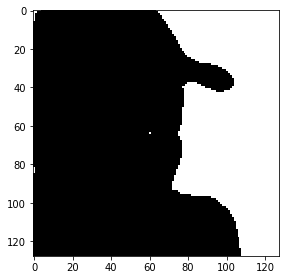

In [ ]:
io.imshow(labels_spatial[22, :, :] == 1)

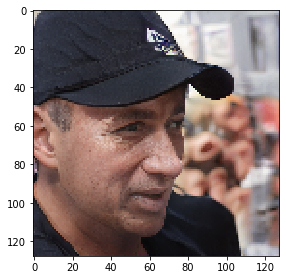

In [ ]:
io.imshow(norm_ip(imgs[22, :, :, :], min=-1.0, max=1.0).permute(1, 2, 0).numpy())

In [ ]:
import pickle

with open("k_means_human_7_layer_9_clusters.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [ ]:
import pickle

with open("k_means_human_7_layer_9_clusters.pkl", "rb") as f:
    kmeans = pickle.load(f)

In [ ]:
import sys, os
sys.path.append("pytorch-segmentation-detection/")
sys.path.insert(0, 'vision/')

In [ ]:
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

fcn = resnet_dilated.Resnet18_8s(num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
def adjust_learning_rate(optimizer, iteration):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    max_iteration = 1000.0
    
    multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
    
    lr = 0.0001 * multiplier
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [ ]:
import torch.optim as optim
import torch.nn as nn

#fcn = Resnet18_8s(num_classes=2)
fcn.cuda()
fcn.train()

#optimizer = optim.SGD(fcn.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)
optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

classification_criterion = nn.CrossEntropyLoss(size_average=True, ignore_index=255).cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
!pip install livelossplot==0.3.4

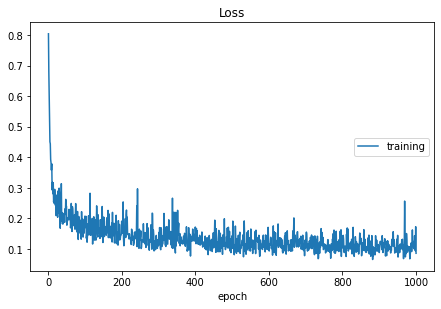

Loss:
training   (min:    0.065, max:    0.804, cur:    0.086)


In [ ]:
import argparse
import math
import os

import torch
import torchvision
from torch import optim
from tqdm import tqdm

from models.stylegan2.model import Generator
import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img

g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

truncation = 0.7

best_distance = 0.0
winner = None

fcn.train()

from livelossplot import PlotLosses

liveloss = PlotLosses()

bn_layer = nn.BatchNorm2d(1, affine=False, track_running_stats=False)

for i in range(1000):

  sample_z = torch.randn(15, 512).cuda()
  style = g_ema.style(sample_z)
  style = mean_latent + truncation * (style - mean_latent)

  with torch.no_grad():

    img_gen, _, features = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)

    img_one = nn.functional.upsample(img_gen,
                                     size=(128, 128),
                                     mode='bilinear',
                                     align_corners=True).clamp(min=-1.0, max=1.0)
    
    features = nn.functional.upsample(features,
                                      size=(128, 128),
                                      mode='bilinear',
                                      align_corners=True).detach()
    
    features_flat = features.permute(0, 2, 3, 1).reshape(-1, 512).cpu().detach().numpy()
    predictions_flat = kmeans.predict(features_flat)
    predictions = predictions_flat.reshape(features.shape[0], features.shape[2], features.shape[3])
    predictions[predictions != 1] = 0
    predictions[predictions == 1] = 1
    labels_batch = torch.from_numpy(predictions)
  
  net_input_img = img_one.cuda()

  optimizer.zero_grad()
  out = fcn(net_input_img)
  loss = classification_criterion(out, labels_batch.long().cuda().squeeze_())
  loss.backward()
  optimizer.step()

  adjust_learning_rate(optimizer, i)

  liveloss.update({'Loss': loss})
  liveloss.draw()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


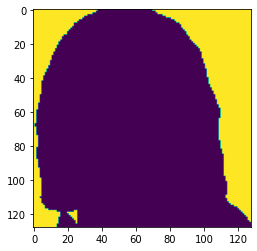

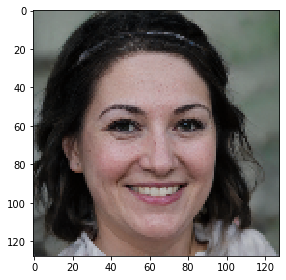

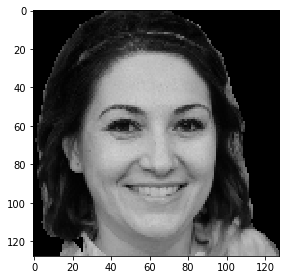

In [ ]:
fcn.eval()

with torch.no_grad():

  sample_z = torch.randn(1, 512).cuda()
  style = g_ema.style(sample_z)
  style = mean_latent + truncation * (style - mean_latent)
  img_gen, _, features = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)
  img_one = nn.functional.upsample(img_gen,
                                   size=(128, 128),
                                   mode='bilinear',
                                   align_corners=True).clamp(min=-1.0, max=1.0)
  net_input_img = img_one.cuda()
  res = fcn(net_input_img)


from matplotlib import pyplot as plt

_, tmp = res.squeeze(0).max(0)

segmentation = tmp.data.cpu().numpy().squeeze()

plt.imshow(segmentation)
plt.show()

to_show = norm_ip(img_one, min=-1.0, max=1.0).squeeze().permute(1, 2, 0).cpu().detach().numpy()

io.imshow(to_show)
io.show()

io.imshow(to_show[:, :, 0] * (segmentation != 1))
io.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


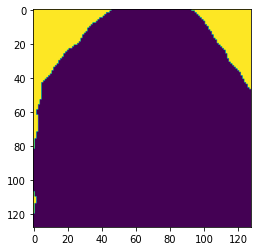

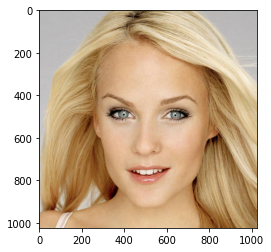

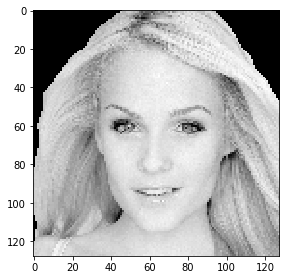

In [ ]:
import skimage.io as io
from matplotlib import pyplot as plt

from PIL import Image

fcn.eval()

img_disp = io.imread('1.jpg')
img = torch.from_numpy(((img_disp / 255.0) * 2.0) - 1.0)
img = img.permute(2, 0, 1).unsqueeze(0).float().cuda()

real_img_input = nn.functional.upsample(img,
                                   size=(128, 128),
                                   mode='bilinear',
                                   align_corners=True).clamp(min=-1.0, max=1.0).detach()

res = fcn(real_img_input)

from matplotlib import pyplot as plt

_, tmp = res.squeeze(0).max(0)

segmentation = tmp.data.cpu().numpy().squeeze()

plt.imshow(segmentation)
plt.show()

plt.imshow(img_disp)
plt.show()

to_show = norm_ip(real_img_input, min=-1.0, max=1.0).squeeze().permute(1, 2, 0).cpu().detach().numpy()

io.imshow(to_show[:, :, 0] * (segmentation != 1))
io.show()

In [ ]:
torch.save(fcn.state_dict(), 'unsup_human.pth')

In [ ]:
import torch

fcn.load_state_dict(torch.load('unsup_human.pth'))
fcn.cuda()
fcn.eval()

Resnet18_8s(
  (resnet18_8s): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1S_9Z3reUsohvBQ7lE7Z7fTcq9Fx6150d'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
!tar zxvf celeb_hq_test_segm.tar.gz

Streaming output truncated to the last 5000 lines.
test/labels/28838.png
test/labels/28051.png
test/labels/28067.png
test/labels/29236.png
test/labels/28911.png
test/labels/28740.png
test/labels/28324.png
test/labels/28049.png
test/labels/28408.png
test/labels/28750.png
test/labels/29362.png
test/labels/28227.png
test/labels/28177.png
test/labels/29565.png
test/labels/29329.png
test/labels/29189.png
test/labels/29826.png
test/labels/28918.png
test/labels/28956.png
test/labels/29399.png
test/labels/28884.png
test/labels/29624.png
test/labels/28562.png
test/labels/28762.png
test/labels/29484.png
test/labels/29294.png
test/labels/29386.png
test/labels/29301.png
test/labels/29466.png
test/labels/28081.png
test/labels/28855.png
test/labels/28349.png
test/labels/28088.png
test/labels/28510.png
test/labels/29763.png
test/labels/29086.png
test/labels/29041.png
test/labels/29738.png
test/labels/29629.png
test/labels/29205.png
test/labels/29853.png
test/labels/28252.png
test/labels/28729.png
tes

In [ ]:
import torch.utils.data as data
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io as io
import os

class CelebAHQ(data.Dataset):
    
    def __init__(self,
             dataset_base_folder_path='',
             train=True,
             joint_transform=None):
        
        self.joint_transform = joint_transform
        self.train = train
        if train:
            self.dataset_base_folder_path = dataset_base_folder_path + 'train/'
            
        else:
            
            self.dataset_base_folder_path = dataset_base_folder_path + 'test/'
        
        self.images_folder_path = self.dataset_base_folder_path + 'images/'
        self.annotations_folder_path = self.dataset_base_folder_path + 'labels/'
        self.filenames = list( map(lambda x: x[:-4], os.listdir(self.images_folder_path) ) )
    
    def __len__(self):
        
        return len(self.filenames)
                              
    def __getitem__(self, index):
        
        filename = self.filenames[index]
        image_path = self.images_folder_path + filename + '.jpg'
        annotation_path = self.annotations_folder_path + filename + '.png'
        image = Image.open(image_path).resize((512, 512), PIL.Image.BILINEAR)
        annotation = Image.open(annotation_path)

        if self.joint_transform is not None:

            image, annotation = self.joint_transform([image, annotation])

        return image, annotation

In [ ]:
from pytorch_segmentation_detection.transforms import ComposeJoint
from torchvision import transforms

transform = ComposeJoint(
                [
                     #[transforms.CenterCrop((1024, 1280)), transforms.CenterCrop((1024, 1280))],
                     #RandomCropJoint(crop_size=(512, 512)),
                     #[transforms.Resize(size=(128, 128)), None],
                     [transforms.ToTensor(), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x) == 0 ).long()) ]
                ])

test_set = CelebAHQ(train=False, joint_transform=transform)

test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                              shuffle=False, num_workers=2, pin_memory=False)

In [ ]:
from sklearn.metrics import confusion_matrix

number_of_classes = 2

labels = range(number_of_classes)

def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image_orig, annotation in test_set_loader:

        image = image_orig.cuda()
        image = (image * 2.0) - 1.0
        image = nn.functional.upsample(image,
                                   size=(128, 128),
                                   mode='bilinear',
                                   align_corners=True)

        logits = fcn(image)

        logits = nn.functional.upsample(logits,
                                        size=(512, 512),
                                        mode='bilinear',
                                        align_corners=True)
        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union, intersection_over_union

In [ ]:
validate() # 0.9157 -- since we changed the order

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(0.8607738295148756, array([0.91576534, 0.80578232]))

In [ ]:
import torch.nn as nn
from sklearn.metrics import confusion_matrix

number_of_classes = 2

labels = range(number_of_classes)

fcn.eval()
    
overall_confusion_matrix = None

i = 0

for image_orig, annotation in test_set_loader:

    image = image_orig.cuda()
    image = (image * 2.0) - 1.0
    image = nn.functional.upsample(image,
                                   size=(128, 128),
                                   mode='bilinear',
                                   align_corners=True)

    logits = fcn(image)

    logits = nn.functional.upsample(logits,
                                    size=(512, 512),
                                    mode='bilinear',
                                    align_corners=True)
    # First we do argmax on gpu and then transfer it to cpu
    logits = logits.data
    _, prediction = logits.max(1)
    prediction = prediction.squeeze(1)

    prediction_np = prediction.cpu().numpy().flatten()
    annotation_np = annotation.numpy().flatten()

    # Mask-out value is ignored by default in the sklearn
    # read sources to see how that was handled

    current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                y_pred=prediction_np,
                                                labels=labels)

    if overall_confusion_matrix is None:


        overall_confusion_matrix = current_confusion_matrix
    else:

        overall_confusion_matrix += current_confusion_matrix
    i = i + 1
    if i == 1:
      break


intersection = np.diag(overall_confusion_matrix)
ground_truth_set = overall_confusion_matrix.sum(axis=1)
predicted_set = overall_confusion_matrix.sum(axis=0)
union =  ground_truth_set + predicted_set - intersection

intersection_over_union = intersection / union.astype(np.float32)
mean_intersection_over_union = np.mean(intersection_over_union)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
